In [1]:
import pandas as pd
import xarray as xr
from pathlib import Path
import datetime
from cftime import num2date
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import RegularGridInterpolator
from scipy.stats import weibull_min
from windrose import WindroseAxes
from scipy.special import gamma
from scipy.integrate import quad
from scipy.interpolate import interp1d

In [2]:
# Define the folder path containing the other NetCDF files
folder_path = Path('..\inputs\WindData')
new_datasets = []  # List to store datasets

for file in folder_path.iterdir():
    ds = xr.open_dataset(file)  # Open each NetCDF file
    new_datasets.append(ds)  # Store dataset in list

# Concatenate along a specific dimension (e.g., 'time' if it exists)
new_combined_ds = xr.concat(new_datasets, dim='time')

# Convert the combined dataset to a pandas DataFrame
WindData = new_combined_ds.to_dataframe().reset_index()

WindData['time'] = WindData['valid_time']
WindData = WindData.drop(columns=['valid_time'])
WindData = WindData.rename(columns={'time': 'valid_time'})
WindData = WindData.drop(columns=['step'])
WindData = WindData.drop(columns=['surface'])

# # Convert all columns except the first to numeric, coercing errors to NaN
WindData.iloc[:, 1:] = WindData.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')
# Drop rows with NaN values
WindData = WindData.dropna()

In [49]:
# Display the combined dataset
WindData

,valid_time,latitude,longitude,number,u10,v10,u100,v100
0,1997-01-01 00:00:00,55.75,7.75,0,-4.416992,-3.372101,-4.495712,-3.377914
1,1997-01-01 00:00:00,55.75,8.00,0,-4.011719,-3.545929,-4.316025,-3.851547
2,1997-01-01 00:00:00,55.50,7.75,0,-5.098633,-3.716827,-5.483994,-3.896469
3,1997-01-01 00:00:00,55.50,8.00,0,-4.603516,-4.034210,-5.179306,-4.446274
4,1997-01-01 01:00:00,55.75,7.75,0,-4.260544,-3.408768,-4.337830,-3.450699
...,...,...,...,...,...,...,...,...
420763,2008-12-31 22:00:00,55.50,8.00,0,3.607391,-7.348846,4.059204,-8.538055
420764,2008-12-31 23:00:00,55.75,7.75,0,3.909058,-7.946991,4.313522,-9.313065
420765,2008-12-31 23:00:00,55.75,8.00,0,3.849487,-7.310272,4.657272,-9.121658
420766,2008-12-31 23:00:00,55.50,7.75,0,3.389526,-7.698944,3.719772,-8.914627


In [50]:
# Separate the wind speeds in the four different points, using the latitude and longitude information

WindData = WindData.rename(columns={'number': 'location'}) # Change the meaning of the existing column 'number' which was not being used

WindData['location'] = list(zip(WindData['longitude'], WindData['latitude'])) # Combines latitude and longitude on the column location



In [51]:
WindData

,valid_time,latitude,longitude,location,u10,v10,u100,v100
0,1997-01-01 00:00:00,55.75,7.75,"(7.75, 55.75)",-4.416992,-3.372101,-4.495712,-3.377914
1,1997-01-01 00:00:00,55.75,8.00,"(8.0, 55.75)",-4.011719,-3.545929,-4.316025,-3.851547
2,1997-01-01 00:00:00,55.50,7.75,"(7.75, 55.5)",-5.098633,-3.716827,-5.483994,-3.896469
3,1997-01-01 00:00:00,55.50,8.00,"(8.0, 55.5)",-4.603516,-4.034210,-5.179306,-4.446274
4,1997-01-01 01:00:00,55.75,7.75,"(7.75, 55.75)",-4.260544,-3.408768,-4.337830,-3.450699
...,...,...,...,...,...,...,...,...
420763,2008-12-31 22:00:00,55.50,8.00,"(8.0, 55.5)",3.607391,-7.348846,4.059204,-8.538055
420764,2008-12-31 23:00:00,55.75,7.75,"(7.75, 55.75)",3.909058,-7.946991,4.313522,-9.313065
420765,2008-12-31 23:00:00,55.75,8.00,"(8.0, 55.75)",3.849487,-7.310272,4.657272,-9.121658
420766,2008-12-31 23:00:00,55.50,7.75,"(7.75, 55.5)",3.389526,-7.698944,3.719772,-8.914627


In [52]:
# Convert from cartessian cordinates of velocity to polar coordinates to obtain wind direction and speed, for every location

WindData['ws_10'] = (WindData['u10']**2 + WindData['v10']**2)**0.5
WindData['wd_10'] = (np.arctan2(WindData['u10'], WindData['v10']) * 360 / (2 * np.pi)) % 360  # Wind direction in degrees (0, 360)



WindData['ws_100'] = (WindData['u100']**2 + WindData['v100']**2)**0.5
WindData['wd_100'] = (np.arctan2(WindData['u100'], WindData['v100']) * 360 / (2 * np.pi)) % 360  # Wind direction in degrees

#separate the wind speeds in the four locations
Location_1 = WindData[WindData['location'] == (7.75, 55.5)]
Location_2 = WindData[WindData['location'] == (8, 55.5)]
Location_3 = WindData[WindData['location'] == (7.75, 55.75)]
Location_4 = WindData[WindData['location'] == (8, 55.75)]

Location_1


,valid_time,latitude,longitude,location,u10,v10,u100,v100,ws_10,wd_10,ws_100,wd_100
2,1997-01-01 00:00:00,55.5,7.75,"(7.75, 55.5)",-5.098633,-3.716827,-5.483994,-3.896469,6.309585,233.908508,6.727307,234.605560
6,1997-01-01 01:00:00,55.5,7.75,"(7.75, 55.5)",-4.927536,-3.668533,-5.261658,-3.858902,6.143187,233.332443,6.525041,233.743668
10,1997-01-01 02:00:00,55.5,7.75,"(7.75, 55.5)",-4.756882,-3.202682,-5.048157,-3.405014,5.734553,236.048676,6.089171,236.000092
14,1997-01-01 03:00:00,55.5,7.75,"(7.75, 55.5)",-4.320511,-2.848724,-4.544479,-3.030075,5.175137,236.601181,5.462018,236.306244
18,1997-01-01 04:00:00,55.5,7.75,"(7.75, 55.5)",-3.832291,-2.976578,-4.007080,-3.160858,4.852470,232.163177,5.103696,231.732986
...,...,...,...,...,...,...,...,...,...,...,...,...
420750,2008-12-31 19:00:00,55.5,7.75,"(7.75, 55.5)",2.796295,-5.041809,2.944473,-5.519547,5.765337,150.986313,6.255823,151.921738
420754,2008-12-31 20:00:00,55.5,7.75,"(7.75, 55.5)",3.144028,-5.754761,3.325317,-6.328659,6.557605,151.350662,7.149102,152.280853
420758,2008-12-31 21:00:00,55.5,7.75,"(7.75, 55.5)",3.314865,-6.379517,3.528244,-7.152359,7.189337,152.543121,7.975258,153.742966
420762,2008-12-31 22:00:00,55.5,7.75,"(7.75, 55.5)",3.494110,-7.592010,3.781860,-8.652313,8.357477,155.286453,9.442721,156.390228


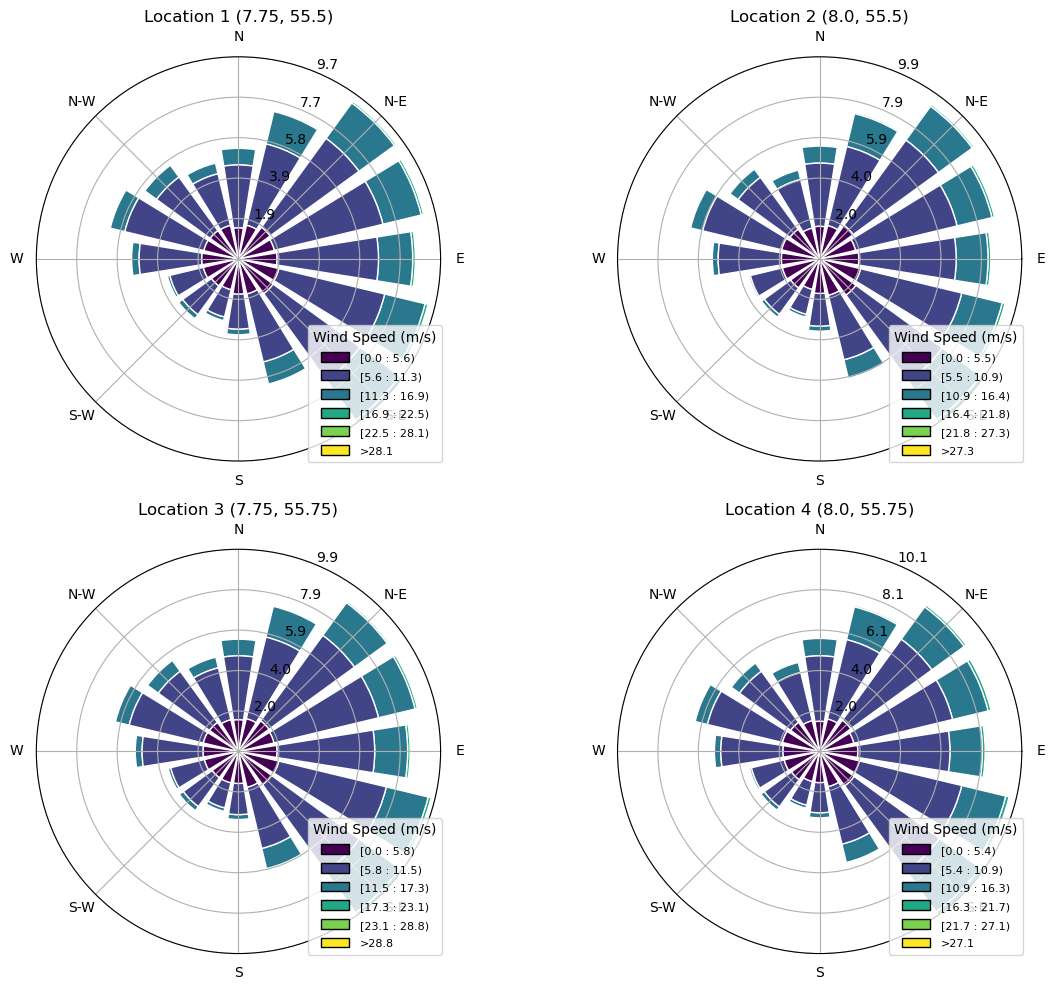

In [53]:
# Create a 2x2 subplot for wind rose plots
fig, axes = plt.subplots(2, 2, subplot_kw={'projection': 'windrose'}, figsize=(12, 10))

# Plot for Location_1
axes[0, 0].bar(Location_1['wd_10'], Location_1['ws_10'], normed=True, opening=0.8, edgecolor='white')
axes[0, 0].set_title("Location 1 (7.75, 55.5)")
axes[0, 0].set_legend(title="Wind Speed (m/s)", loc='lower right')

# Plot for Location_2
axes[0, 1].bar(Location_2['wd_10'], Location_2['ws_10'], normed=True, opening=0.8, edgecolor='white')
axes[0, 1].set_title("Location 2 (8.0, 55.5)")
axes[0, 1].set_legend(title="Wind Speed (m/s)", loc='lower right')

# Plot for Location_3
axes[1, 0].bar(Location_3['wd_10'], Location_3['ws_10'], normed=True, opening=0.8, edgecolor='white')
axes[1, 0].set_title("Location 3 (7.75, 55.75)")
axes[1, 0].set_legend(title="Wind Speed (m/s)", loc='lower right')

# Plot for Location_4
axes[1, 1].bar(Location_4['wd_10'], Location_4['ws_10'], normed=True, opening=0.8, edgecolor='white')
axes[1, 1].set_title("Location 4 (8.0, 55.75)")
axes[1, 1].set_legend(title="Wind Speed (m/s)", loc='lower right')

plt.tight_layout()
plt.show()

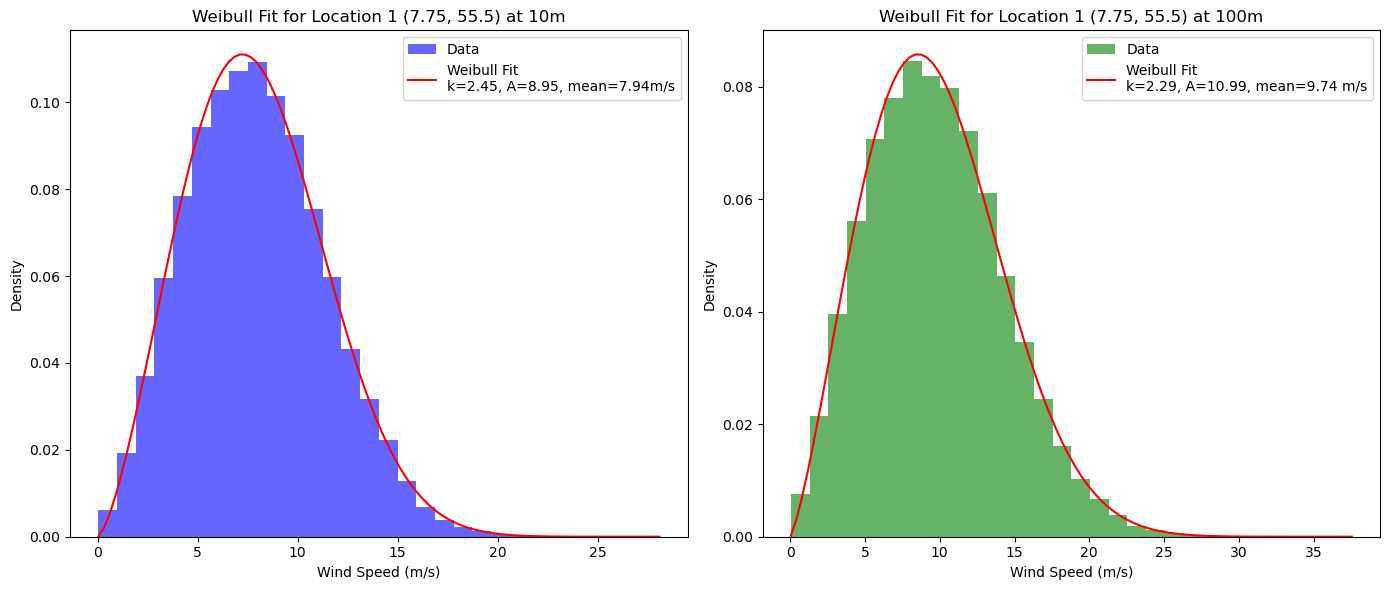

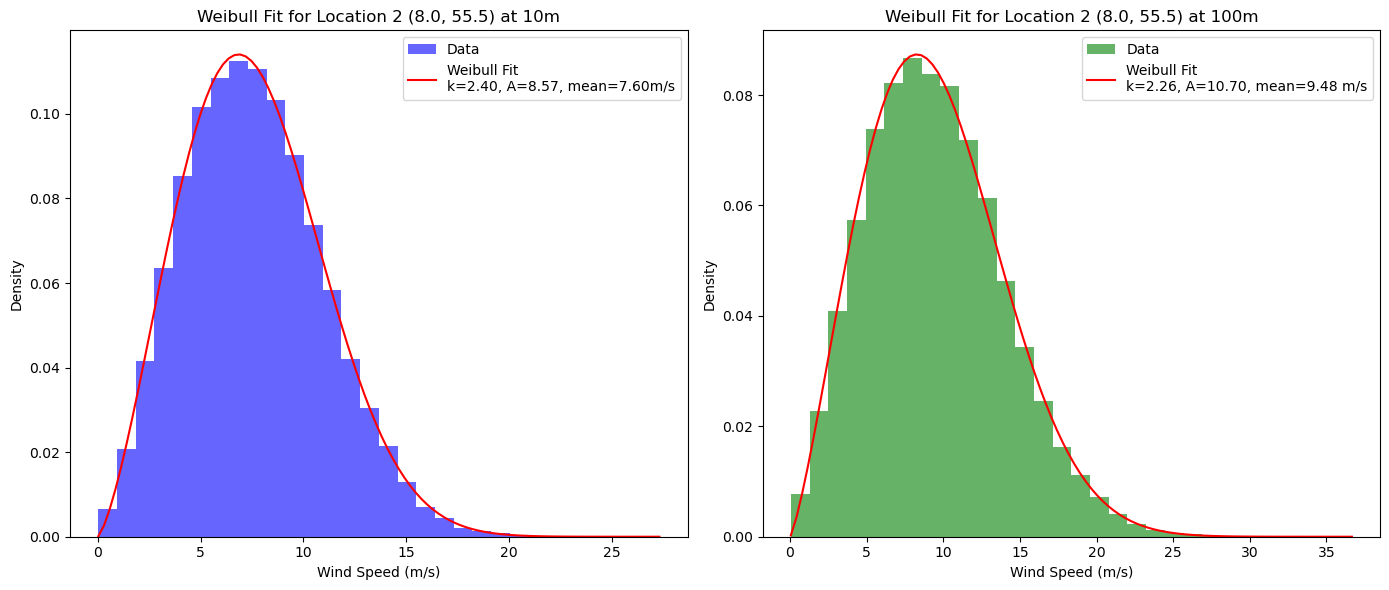

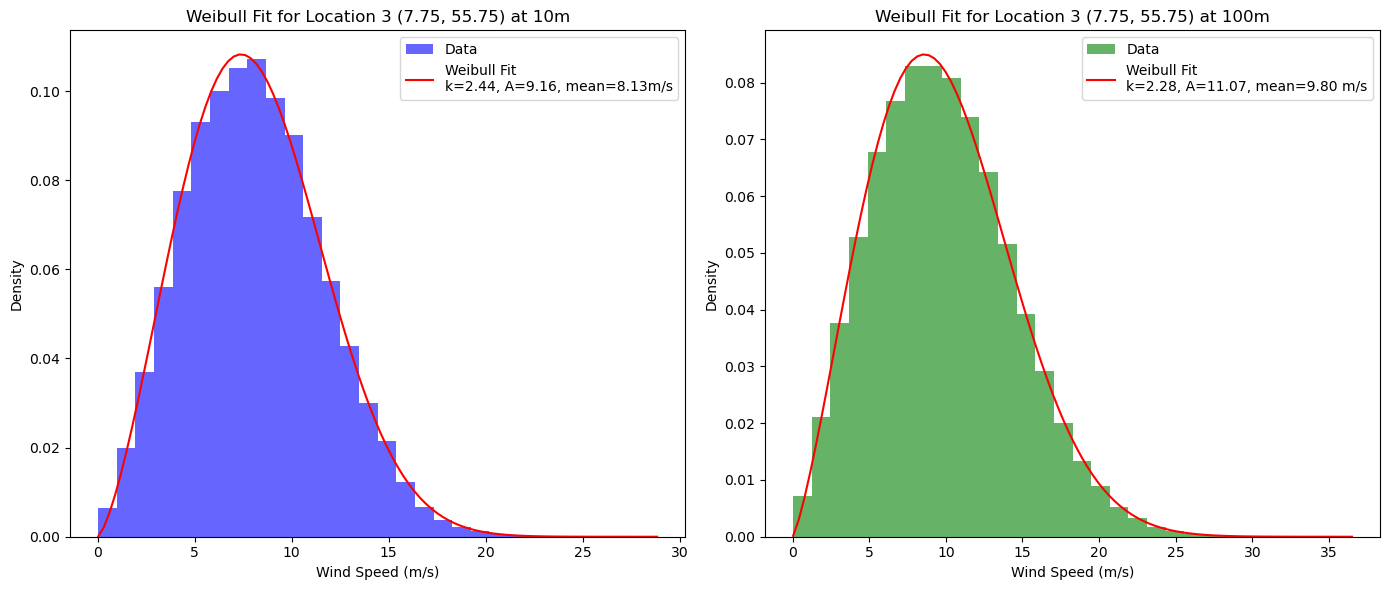

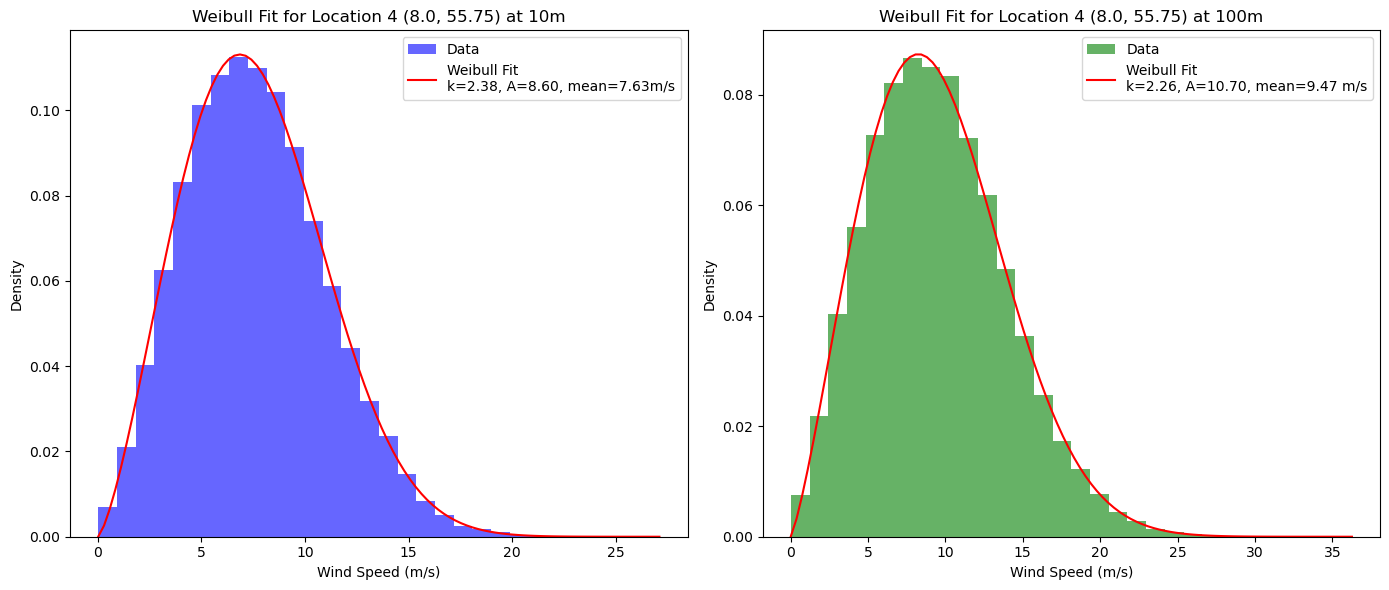

In [54]:
# Array to store mean wind speeds
mean_speeds = []

# Function to fit Weibull distribution, plot, and calculate mean speed
def fit_weibull_and_store_mean(location_data, location_name):
    # Extract wind speed data at 10m and 100m heights
    wind_speeds_10 = location_data['ws_10']
    wind_speeds_100 = location_data['ws_100']
    
    # Fit Weibull distribution for 10m
    shape_10, loc_10, scale_10 = weibull_min.fit(wind_speeds_10, floc=0)  # Fix location to 0
    mean_10 = scale_10 * gamma(1 + 1 / shape_10)  # Calculate mean speed for 10m
    
    # Fit Weibull distribution for 100m
    shape_100, loc_100, scale_100 = weibull_min.fit(wind_speeds_100, floc=0)  # Fix location to 0
    mean_100 = scale_100 * gamma(1 + 1 / shape_100)  # Calculate mean speed for 100m
    
    # Store mean speeds in the array
    mean_speeds.append({'location': location_name, 'mean_10m': mean_10, 'mean_100m': mean_100})
    
    # Generate data for plotting
    x_10 = np.linspace(wind_speeds_10.min(), wind_speeds_10.max(), 100)
    pdf_10 = weibull_min.pdf(x_10, shape_10, loc_10, scale_10)
    
    x_100 = np.linspace(wind_speeds_100.min(), wind_speeds_100.max(), 100)
    pdf_100 = weibull_min.pdf(x_100, shape_100, loc_100, scale_100)
    
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot for 10m
    axes[0].hist(wind_speeds_10, bins=30, density=True, alpha=0.6, color='blue', label='Data')
    axes[0].plot(x_10, pdf_10, 'r-', label=f'Weibull Fit\nk={shape_10:.2f}, A={scale_10:.2f}, mean={mean_10:.2f}m/s')
    axes[0].set_title(f'Weibull Fit for {location_name} at 10m')
    axes[0].set_xlabel('Wind Speed (m/s)')
    axes[0].set_ylabel('Density')
    axes[0].legend()
    
    # Plot for 100m
    axes[1].hist(wind_speeds_100, bins=30, density=True, alpha=0.6, color='green', label='Data')
    axes[1].plot(x_100, pdf_100, 'r-', label=f'Weibull Fit\nk={shape_100:.2f}, A={scale_100:.2f}, mean={mean_100:.2f} m/s')
    axes[1].set_title(f'Weibull Fit for {location_name} at 100m')
    axes[1].set_xlabel('Wind Speed (m/s)')
    axes[1].set_ylabel('Density')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

# Fit Weibull distribution and store mean speeds for each location
fit_weibull_and_store_mean(Location_1, "Location 1 (7.75, 55.5)")
fit_weibull_and_store_mean(Location_2, "Location 2 (8.0, 55.5)")
fit_weibull_and_store_mean(Location_3, "Location 3 (7.75, 55.75)")
fit_weibull_and_store_mean(Location_4, "Location 4 (8.0, 55.75)")


In [55]:
# Coordinates and data organization
points = np.array([[7.75, 55.5], [8, 55.5], [7.75, 55.75], [8, 55.75]])
x_coords = np.unique(points[:, 0])  # [7.75, 8.0]
y_coords = np.unique(points[:, 1])  # [55.5, 55.75]

# Extract wind speed and direction data
ws_data10 = np.array([loc['ws_10'].values for loc in [Location_1, Location_2, Location_3, Location_4]])
wd_data10 = np.array([loc['wd_10'].values for loc in [Location_1, Location_2, Location_3, Location_4]])
ws_data100 = np.array([loc['ws_100'].values for loc in [Location_1, Location_2, Location_3, Location_4]])
wd_data100 = np.array([loc['wd_100'].values for loc in [Location_1, Location_2, Location_3, Location_4]])

# Reshape into (2,2,time)
ws_grid10 = ws_data10.reshape(2, 2, -1)
ws_grid100 = ws_data100.reshape(2, 2, -1)

wd_grid10 = wd_data10.reshape(2, 2, -1)
wd_grid100 = wd_data100.reshape(2, 2, -1)

# Wind direction conversion into vectors
def degree_to_vector(degrees):
    rad = np.deg2rad(degrees)
    return np.stack([np.cos(rad), np.sin(rad)], axis=-1)

wd_vectors10 = degree_to_vector(wd_grid10)  # shape (2, 2, time, 2)
wd_vectors100 = degree_to_vector(wd_grid100)

# Prepare interpolators for each time step
# Important: RegularGridInterpolator expects input grid matching the first two dims
ws_interpolators10 = [RegularGridInterpolator((x_coords, y_coords), ws_grid10[:, :, t], method='linear') for t in range(ws_grid10.shape[2])]
ws_interpolators100 = [RegularGridInterpolator((x_coords, y_coords), ws_grid100[:, :, t], method='linear') for t in range(ws_grid100.shape[2])]

wd_interpolators10 = [RegularGridInterpolator((x_coords, y_coords), wd_vectors10[:, :, t, :], method='linear') for t in range(wd_vectors10.shape[2])]
wd_interpolators100 = [RegularGridInterpolator((x_coords, y_coords), wd_vectors100[:, :, t, :], method='linear') for t in range(wd_vectors100.shape[2])]

# Define your target
target = (7.90, 55.60)  # (x, y)

# Interpolate across all time steps
interp_speed10 = np.array([interp(target) for interp in ws_interpolators10])
interp_speed100 = np.array([interp(target) for interp in ws_interpolators100])

interp_vector10 = np.array([interp(target) for interp in wd_interpolators10])
interp_vector100 = np.array([interp(target) for interp in wd_interpolators100])

# Convert vectors back to degrees
interp_wd10 = np.rad2deg(np.arctan2(interp_vector10[:, 1], interp_vector10[:, 0])) % 360
interp_wd100 = np.rad2deg(np.arctan2(interp_vector100[:, 1], interp_vector100[:, 0])) % 360

# Example output for first time step
print(f"Interpolated wind speed at 10m (first timestep): {interp_speed10[0]:.2f} m/s")
print(f"Interpolated wind direction at 10m (first timestep): {interp_wd10[0]:.1f} degrees")
print("---------------------------------------------------------------------")
print(f"Interpolated wind speed at 100m (first timestep): {interp_speed100[0]:.2f} m/s")
print(f"Interpolated wind direction at 100m (first timestep): {interp_wd100[0]:.1f} degrees")


Interpolated wind speed at 10m (first timestep): 5.78 m/s
Interpolated wind direction at 10m (first timestep): 231.3 degrees
---------------------------------------------------------------------
Interpolated wind speed at 100m (first timestep): 6.12 m/s
Interpolated wind direction at 100m (first timestep): 231.7 degrees


C:\Users\srodr\AppData\Local\Temp\ipykernel_7672\879269301.py:27: RuntimeWarning: divide by zero encountered in log
  return u_ref * (np.log(z / z0) / np.log(z_ref / z0))


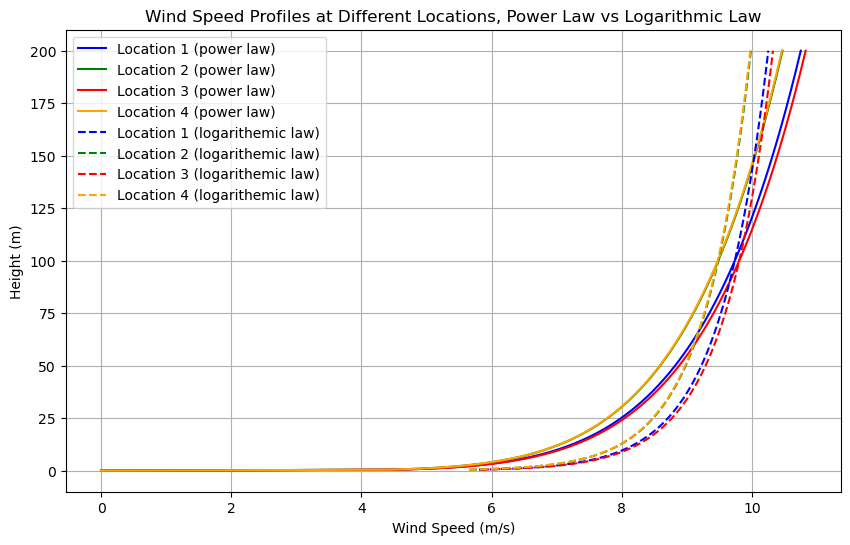

Wind Speed at Target Height (70 m):
Location 1: 10.483077669741105 m/s
Location 2: 10.035338760353007 m/s
Location 3: 10.729064095233868 m/s
Location 4: 10.0712414041818 m/s


C:\Users\srodr\AppData\Local\Temp\ipykernel_7672\879269301.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Location_1[f'ws_{z_target}'] = mean_speeds[0]['mean_10m'] * (z_target / z_ref_10)**alpha
C:\Users\srodr\AppData\Local\Temp\ipykernel_7672\879269301.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Location_2[f'ws_{z_target}'] = mean_speeds[1]['mean_10m'] * (z_target / z_ref_10)**alpha
C:\Users\srodr\AppData\Local\Temp\ipykernel_7672\879269301.py:61: SettingWithCopyWarning: 
A value is trying t

In [56]:
# Define the reference heights and target height
z_ref_10 = 10  # Reference height for ws_10
z_ref_100 = 100  # Reference height for ws_100
alpha = 1 / 7  # Wind shear exponent (empirical for neutral stability conditions)

z_target = 70  # Set the target height

max_z = 200  # Maximum height for wind profile
min_z = 0  # Minimum height for wind profile

z = np.linspace(min_z, max_z, max_z*2)  # Height boundaries for wind profile

'''
For WRA, it is more accurate to use the wind speed reference as close to the hub height as possible.
So the bes option is to use the wind speed at 100 m height.
'''
### POWER LAW PROFILE ###
# Compute wind profiles using z_ref_100 as the reference height
u_location1 = mean_speeds[0]['mean_100m'] * (z / z_ref_100)**alpha
u_location2 = mean_speeds[1]['mean_100m'] * (z / z_ref_100)**alpha
u_location3 = mean_speeds[2]['mean_100m'] * (z / z_ref_100)**alpha
u_location4 = mean_speeds[3]['mean_100m'] * (z / z_ref_100)**alpha

### LOGARITHEMIC LAW PROFILE ###
def offshore_wind_speed(z, u_ref, z_ref, z0):
    """Compute wind speed at height z using logarithmic profile."""
    return u_ref * (np.log(z / z0) / np.log(z_ref / z0))

# Compute wind profiles using z_ref_100 as the reference height
z0=0.0002  # Roughness length for offshore wind (typical value, adjust as needed)

u_location1_log = offshore_wind_speed(z, mean_speeds[0]['mean_100m'], z_ref_100, z0)
u_location2_log = offshore_wind_speed(z, mean_speeds[1]['mean_100m'], z_ref_100, z0)
u_location3_log = offshore_wind_speed(z, mean_speeds[2]['mean_100m'], z_ref_100, z0)
u_location4_log = offshore_wind_speed(z, mean_speeds[3]['mean_100m'], z_ref_100, z0)


plt.figure(figsize=(10, 6))

# Plot wind profiles using z_ref_100 as the reference height
plt.plot(u_location1, z, label='Location 1 (power law)', color='blue')
plt.plot(u_location2, z, label='Location 2 (power law)', color='green')
plt.plot(u_location3, z, label='Location 3 (power law)', color='red')
plt.plot(u_location4, z, label='Location 4 (power law)', color='orange')

plt.plot(u_location1_log, z,'--', label='Location 1 (logarithemic law)', color='blue')
plt.plot(u_location2_log, z,'--', label='Location 2 (logarithemic law)', color='green')
plt.plot(u_location3_log, z,'--', label='Location 3 (logarithemic law)', color='red')
plt.plot(u_location4_log, z,'--', label='Location 4 (logarithemic law)', color='orange')

plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Height (m)')
plt.title('Wind Speed Profiles at Different Locations, Power Law vs Logarithmic Law')
plt.legend()
plt.grid()
plt.show()

# Compute wind speed at z_target for each location using the power law profile
Location_1[f'ws_{z_target}'] = mean_speeds[0]['mean_10m'] * (z_target / z_ref_10)**alpha
Location_2[f'ws_{z_target}'] = mean_speeds[1]['mean_10m'] * (z_target / z_ref_10)**alpha
Location_3[f'ws_{z_target}'] = mean_speeds[2]['mean_10m'] * (z_target / z_ref_10)**alpha
Location_4[f'ws_{z_target}'] = mean_speeds[3]['mean_10m'] * (z_target / z_ref_10)**alpha

# Display the wind speed at the target height for each location
print(f"Wind Speed at Target Height ({z_target} m):")
print(f"Location 1: {Location_1[f'ws_{z_target}'].values[0]} m/s")
print(f"Location 2: {Location_2[f'ws_{z_target}'].values[0]} m/s")
print(f"Location 3: {Location_3[f'ws_{z_target}'].values[0]} m/s")
print(f"Location 4: {Location_4[f'ws_{z_target}'].values[0]} m/s")



Weibull parameters at 100m: k=2.29, A=10.91, mean=9.66m/s
Wind speed at target height (70m): 9.18 m/s


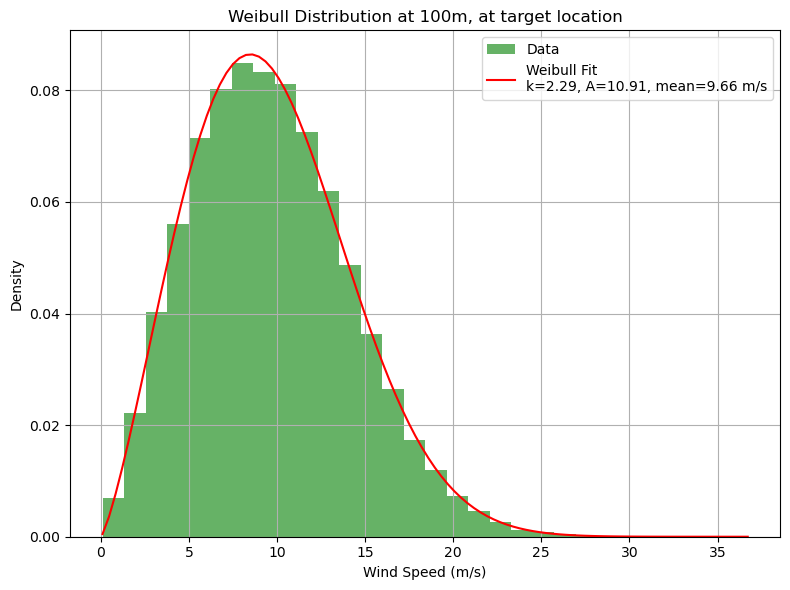

In [57]:
# Fit Weibull distribution for wind speed at 100m height, using the extrapolated ws and wd data calculated before
k_ext, loc_100, A_ext = weibull_min.fit(interp_speed100, floc=0)  # Fix location to 0
u_mean_ext = A_ext * gamma(1 + 1 / k_ext)  # Calculate mean speed for 100m

# Compute wind speed at z_target using the power law profile
ws_z_target = u_mean_ext * (z_target / z_ref_100) ** alpha

# Display results
print(f'Weibull parameters at 100m: k={k_ext:.2f}, A={A_ext:.2f}, mean={u_mean_ext:.2f}m/s')
print(f'Wind speed at target height ({z_target}m): {ws_z_target:.2f} m/s')

# Generate data for plotting Weibull distribution at 100m
x_100 = np.linspace(interp_speed100.min(), interp_speed100.max(), 100)
pdf_100 = weibull_min.pdf(x_100, k_ext, loc_100, A_ext)

# Create a plot for the Weibull distribution at 100m
plt.figure(figsize=(8, 6))
plt.hist(interp_speed100, bins=30, density=True, alpha=0.6, color='green', label='Data')
plt.plot(x_100, pdf_100, 'r-', label=f'Weibull Fit\nk={k_ext:.2f}, A={A_ext:.2f}, mean={u_mean_ext:.2f} m/s')
plt.title('Weibull Distribution at 100m, at target location')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


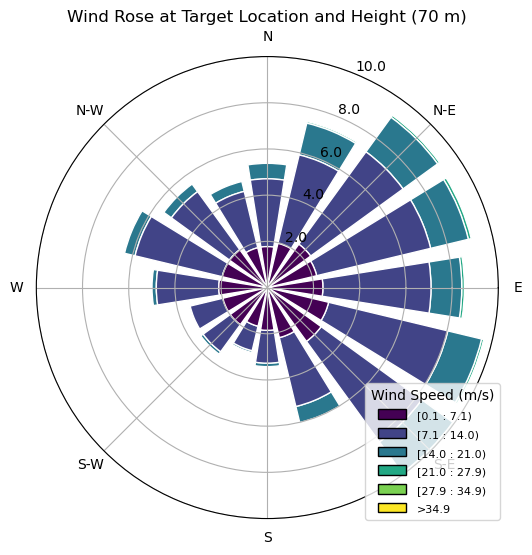

In [58]:

u10, v10 = degree_to_vector(interp_wd10).T
u100, v100 = degree_to_vector(interp_wd100).T

def linear_interp(z0, z1, v0, v1, z_target):
    return v0 + (v1 - v0) * (z_target - z0) / (z1 - z0)

# Interpolate u and v separately
if z_ref_10 < z_target < z_ref_100:
    u_target = linear_interp(z_ref_10, z_ref_100, u10, u100, z_target)
    v_target = linear_interp(z_ref_10, z_ref_100, v10, v100, z_target)
elif z_target > z_ref_100:
    u_target = u100
    v_target = v100
else: # z_target < z_ref_10
    u_target = u10
    v_target = v10

wd_target = (np.rad2deg(np.arctan2(v_target, u_target))) % 360

ws_target = interp_speed100 * (z_target / z_ref_100) ** alpha

# Create a wind rose plot for the interpolated wind direction and speed at the target height
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(projection='windrose'))
ax.bar(wd_target, ws_target, normed=True, opening=0.8, edgecolor='white')
ax.set_title(f'Wind Rose at Target Location and Height ({z_target} m)')
ax.set_legend(title="Wind Speed (m/s)", loc='lower right')
plt.show()


In [60]:
NREL_15MW_path = Path(r'..\inputs\NREL_Reference_15MW_240.csv')
NREL_5MW_path = Path(r'..\inputs\NREL_Reference_5MW_126.csv')

NREL_15MW = pd.read_csv(NREL_15MW_path, sep=',', header=0)
NREL_5MW = pd.read_csv(NREL_5MW_path, sep=',', header=0)

# Create power curve function, interpolating in-between values
NREL_15MW_PC_func = interp1d(NREL_15MW['Wind Speed [m/s]'].values, NREL_15MW['Power [kW]'].values, bounds_error=False, fill_value=0)
NREL_5MW_PC_func = interp1d(NREL_5MW['Wind Speed [m/s]'].values, NREL_5MW['Power [kW]'].values, bounds_error=False, fill_value=0)

def weibull_pdf(u, k, A):
    """Probability density function f(u) for wind speeds."""
    return (k / A) * (u / A)**(k - 1) * np.exp(-(u / A)**k)

def calculate_aep(power_curve_func, k, A, cut_in, cut_out, eta):
    """
    Calculate net AEP using numerical integration.
    
    Args:
        power_curve_func (function): Interpolated power curve function P(u) in kW
        k (float): Weibull shape parameter
        A (float): Weibull scale parameter
        cut_in (float): Turbine cut-in wind speed (m/s)
        cut_out (float): Turbine cut-out wind speed (m/s)
        eta (float): Total system efficiency (1 - losses)
    """
    def integrand(u):
        return power_curve_func(u) * weibull_pdf(u, k, A)
    
    # Perform numerical integration
    integral, _ = quad(integrand, cut_in, cut_out)
    
    # Calculate AEP (convert kWh to MWh)
    AEP = eta * 8760 * integral / 1000000  # GWh/year
    return AEP

# Example usage
k = k_ext  # Weibull shape parameter of the TARGET location
A = A_ext  # Weibull scale parameter of the TARGET location

AEP_NREL_15MW = calculate_aep(NREL_15MW_PC_func, k, A, np.min(NREL_15MW['Wind Speed [m/s]'].values), np.max(NREL_15MW['Wind Speed [m/s]'].values), 1)
AEP_NREL_5MW = calculate_aep(NREL_5MW_PC_func, k, A, np.min(NREL_5MW['Wind Speed [m/s]'].values), np.max(NREL_5MW['Wind Speed [m/s]'].values), 1)

print(f"Annual Energy Production (AEP) with NREL 15MW: {AEP_NREL_15MW:.2f} GWh/year")
print(f"Annual Energy Production (AEP) with NREL 5MW: {AEP_NREL_5MW:.2f} GWh/year")

Annual Energy Production (AEP) with NREL 15MW: 76.75 GWh/year
Annual Energy Production (AEP) with NREL 5MW: 24.61 GWh/year


C:\Users\srodr\AppData\Local\Temp\ipykernel_7672\3411831263.py:31: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral, _ = quad(integrand, cut_in, cut_out)
